## Data Cleaning and Preparation
- Downloading the dataset
- Re-encoding the categorical variables
- Doing the train/validation/test split

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
path = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

!wget $path

--2025-02-01 18:44:19--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
connected. to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.1’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.1s    

2025-02-01 18:44:20 (1.41 MB/s) - ‘CreditScoring.csv.1’ saved [182489/182489]



In [6]:
df = pd.read_csv('CreditScoring.csv')

In [7]:
df.columns = df.columns.str.lower()

In [8]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [9]:
for c in ['income','assets','debt']:
    df[c] = df[c].replace(99999999, np.nan)

In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [11]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

In [15]:
del df_train['status']
del df_val['status']
del df_test['status']

## Decision trees
- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of a tree

In [41]:
# Decision Trees比较直白的展现方式
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [42]:
xi = df_train.iloc[0].to_dict()
assess_risk(xi)

'ok'

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [17]:
train_dict = df_train.fillna(0).to_dict(orient='records')

In [18]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [22]:
val_dict = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dict)

In [63]:
y_pred = dt.predict_proba(X_val)[:,1]

In [66]:
roc_auc_score(y_val, y_pred)

0.6548400377806302

#### Apply parameter (max_depth=3) to Decision Trees Model

In [67]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3)

In [70]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print('train auc:', auc)

train auc: 0.7761016984958594


In [68]:
y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('val auc:', auc)

val auc: 0.7389079944782155


In [71]:
from sklearn.tree import export_text

In [79]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## Decision Tree Learning Algorithm
- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- Decision tree learning algorithm

#### Example1

In [80]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [81]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


In [82]:
from IPython.display import display

In [83]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    display(df_right)
    
    print(T)

0


,assets,status
2,0,default


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


0
2000


,assets,status
1,2000,default
2,0,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


2000
3000


,assets,status
1,2000,default
2,0,default
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


3000
4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


4000
5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
0,8000,default
6,9000,ok


5000
8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
6,9000,ok


8000


#### Example2

In [85]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [86]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [87]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [88]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        # 计算每个class的misclassification rate/impurity rate
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('#####################')

#####################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

#####################


## Decision Tree Parameter Tuning
- Select `max_depth`
- Select `min_samples_leaf`

In [91]:
for d in [1,2,3,4,5,6,10,15,20,None]: # None means no depth restriction
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print(f'depth: {d} -> auc: {round(auc,3)}')

depth: 1 -> auc: 0.606
depth: 2 -> auc: 0.669
depth: 3 -> auc: 0.739
depth: 4 -> auc: 0.761
depth: 5 -> auc: 0.766
depth: 6 -> auc: 0.761
depth: 10 -> auc: 0.698
depth: 15 -> auc: 0.653
depth: 20 -> auc: 0.651
depth: None -> auc: 0.648


In [97]:
scores = []
for d in [4,5,6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d,s,round(auc,3)))
        print(f'depth: {d}, leaf: {s} -> auc: {round(auc,3)}')

depth: 4, leaf: 1 -> auc: 0.761
depth: 4, leaf: 5 -> auc: 0.761
depth: 4, leaf: 10 -> auc: 0.761
depth: 4, leaf: 15 -> auc: 0.764
depth: 4, leaf: 20 -> auc: 0.761
depth: 4, leaf: 500 -> auc: 0.68
depth: 4, leaf: 100 -> auc: 0.756
depth: 4, leaf: 200 -> auc: 0.747
depth: 5, leaf: 1 -> auc: 0.767
depth: 5, leaf: 5 -> auc: 0.768
depth: 5, leaf: 10 -> auc: 0.762
depth: 5, leaf: 15 -> auc: 0.772
depth: 5, leaf: 20 -> auc: 0.774
depth: 5, leaf: 500 -> auc: 0.68
depth: 5, leaf: 100 -> auc: 0.763
depth: 5, leaf: 200 -> auc: 0.759
depth: 6, leaf: 1 -> auc: 0.762
depth: 6, leaf: 5 -> auc: 0.762
depth: 6, leaf: 10 -> auc: 0.778
depth: 6, leaf: 15 -> auc: 0.785
depth: 6, leaf: 20 -> auc: 0.773
depth: 6, leaf: 500 -> auc: 0.68
depth: 6, leaf: 100 -> auc: 0.776
depth: 6, leaf: 200 -> auc: 0.768


In [108]:
df_scores = pd.DataFrame(data=scores, columns=['max_depth','min_samples_leaf','auc'])
df_scores.sort_values('auc', ascending=False)

,max_depth,min_samples_leaf,auc
19,6,15,0.785
18,6,10,0.778
22,6,100,0.776
12,5,20,0.774
20,6,20,0.773
11,5,15,0.772
23,6,200,0.768
9,5,5,0.768
8,5,1,0.767
3,4,15,0.764


In [112]:
df_scores_pivot=df_scores.pivot(index='min_samples_leaf',
                               columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.762
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.773
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

In [66]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

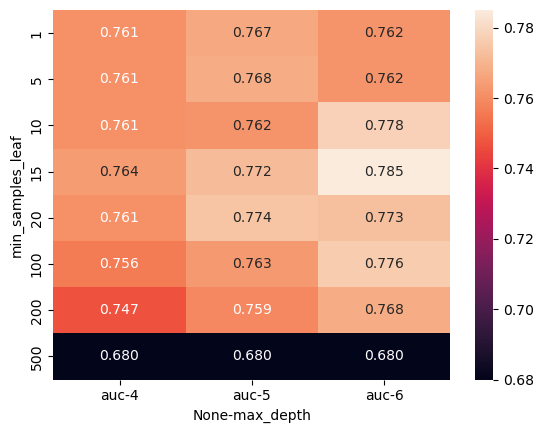

In [115]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [117]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [123]:
print(export_text(
    dt, 
    feature_names=list(dv.get_feature_names_out())))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- income <= 20.00
|   |   |   |   |   |--- seniority <= 1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- seniority >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  20.00
|   |   |   |   |   |--- expenses <= 71.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- expenses >  71.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  4250.00
|   |   |   |   |--- debt <= 1600.00
|   |   |   |   |   |--- seniority <= 2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- seniority >  2.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- debt >  1600.00
|   |   |   |   |   |--- class: 1
|   |   |--- income >  74.50
|   |   |   |--- seniority <= 5.50
|   |   |   |   |--- amount <= 1330.00
|   |   |   |   |   |--- assets <= 3326.00
|   |   |   |   |   |   |--- clas

## Ensembles and Random Forest
- Boards of experts
- Ensembling models
- Random forest-ensembling decision tress
- Tuning random forest

In [125]:
from sklearn.ensemble import RandomForestClassifier

In [136]:
# n_estimators: the number of trees in forest
# each tree randomly reads different subset of data
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [137]:
y_pred = rf.predict_proba(X_val)[:,1]

In [138]:
auc = roc_auc_score(y_val, y_pred)

In [139]:
auc

0.7744726453706618

#### Tuning `n_estimators` Parameter
- 设置不同forest含trees的数量，得出最佳结果

In [154]:
scores = []
for n in range(10,201,10):
    rf = RandomForestClassifier(n_estimators = n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [155]:
df_scores = pd.DataFrame(data=scores, columns=['n_estimator','auc'])

In [156]:
df_scores

,n_estimator,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082
5,60,0.816458
6,70,0.817321
7,80,0.816307
8,90,0.816824
9,100,0.817599


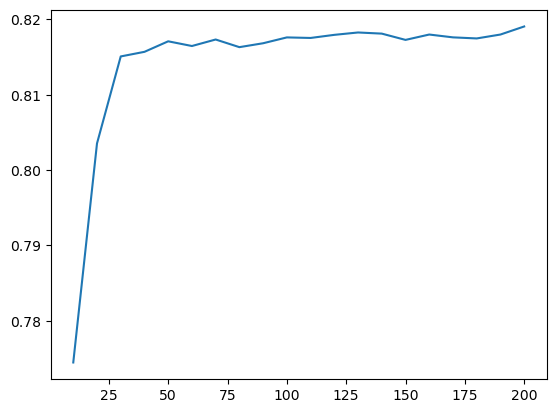

In [157]:
# 从图像中可以看出，当n_estimators=50时，auc值开始缓慢生长
plt.plot(df_scores.n_estimator, df_scores.auc)

#### Tuning `n_estimators` and `max_depth` Parameters

In [161]:
scores = []
for d in [5,10,15]:    
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators = n, 
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [162]:
df_scores = pd.DataFrame(data=scores, columns=['max_depth','n_estimator','auc'])
df_scores

,max_depth,n_estimator,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878
5,5,60,0.801167
6,5,70,0.802251
7,5,80,0.803244
8,5,90,0.803616
9,5,100,0.804452


max_depth=5
max_depth=10
max_depth=15


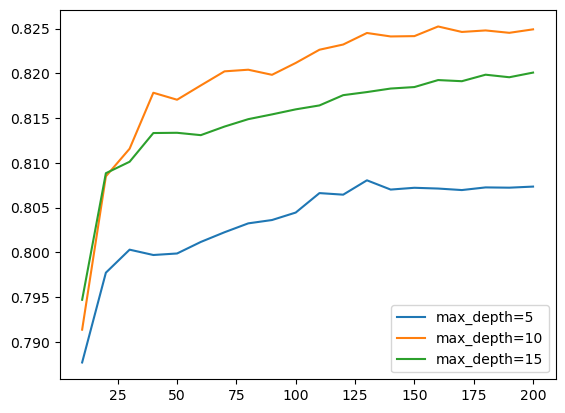

In [166]:
for d in [5,10,15]:
    df_subset = df_scores[df_scores.max_depth == d]
    print(f'max_depth={d}')
    plt.plot(df_subset.n_estimator, df_subset.auc, label=f'max_depth={d}')
plt.legend()

In [ ]:
# max_depth = 10

In [168]:
scores = []
for s in [1,3,5,10,50]:    
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators = n, 
                                    max_depth=10, #从之前的测试中得出，max_depth=10，auc值最高
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [169]:
df_scores = pd.DataFrame(data=scores, columns=['min_samples_leaf','n_estimator','auc'])
df_scores

,min_samples_leaf,n_estimator,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058
...,...,...,...
95,50,160,0.805929
96,50,170,0.805172
97,50,180,0.805324
98,50,190,0.805596


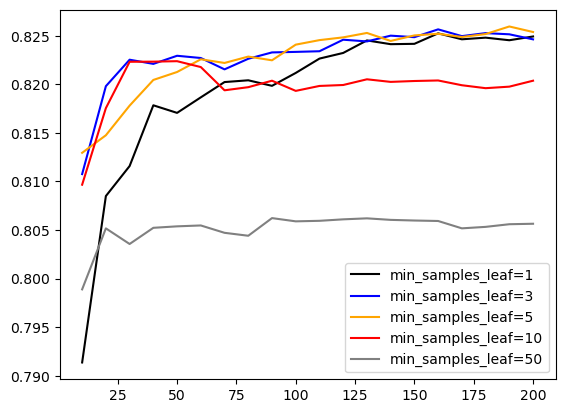

In [195]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_sampels_leaf_values = [1, 3, 5, 10, 50]

for s, color in zip(min_sampels_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimator, df_subset.auc, label=f'min_samples_leaf={s}', color=color)
plt.legend()

In [ ]:
# min_samples_leaf = 3

In [ ]:
rf = RandomForestClassifier(n_estimators=10,
                           max_depth=10,
                           min_samples_leaf=3, #从上面的图片得出来，min_samples_leaf=3,auc值最高
                           random_state=1)
rf.fit(X_train, y_train)

## Gradient boosting and XGBoost
- Gradient boosting vs random forest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output

In [4]:
import xgboost as xgb

In [23]:
# DMatrix() method transform dataset to XGBoost required dataset format
featurs = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(featurs))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(featurs))

In [25]:
xgb_params={
    'eta':0.3, # learning rate
    'max_depth':6, 
    'min_child_weight':1, # same as min_samples_leaf
    'objective':'binary:logistic',
    'nthread':8, # cores
    'seed':1, # random state
    'verbosity':1 # training warning
}
# num_boost_round: how many trees to grow
model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [26]:
y_pred = model.predict(dval)

In [27]:
roc_auc_score(y_val, y_pred)

0.8072491584122448

In [29]:
watchlist = [(dtrain, 'train'),(dval, 'val')]

In [71]:

%%capture output 

#capture "print-out" message and store it in output variable

xgb_params={
    'eta':0.3, # learning rate
    'max_depth':6, 
    'min_child_weight':1, # same as min_samples_leaf
    'objective':'binary:logistic',
    'eval_metric':'auc', # use auc to evaluate model
    'nthread':8, # cores
    'seed':1, # random state
    'verbosity':1 # training warning
}
# num_boost_round: how many trees to grow
model = xgb.train(xgb_params, 
                  dtrain, 
                  num_boost_round=200, # num_boost_round: how many trees to grow
                  evals=watchlist, # show model eval results pairwise of train and val
                  verbose_eval=5, # show model evals results in every 5 steps   
                 )

In [60]:
s = output.stdout
print(s)

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	train-auc:0.97953	val-auc:0.81686
[30]	train-auc:0.98579	val-auc:0.81543
[35]	train-auc:0.99011	val-auc:0.81206
[40]	train-auc:0.99421	val-auc:0.80922
[45]	train-auc:0.99548	val-auc:0.80842
[50]	train-auc:0.99653	val-auc:0.80918
[55]	train-auc:0.99765	val-auc:0.81114
[60]	train-auc:0.99817	val-auc:0.81172
[65]	train-auc:0.99887	val-auc:0.80798
[70]	train-auc:0.99934	val-auc:0.80870
[75]	train-auc:0.99965	val-auc:0.80555
[80]	train-auc:0.99979	val-auc:0.80549
[85]	train-auc:0.99988	val-auc:0.80374
[90]	train-auc:0.99993	val-auc:0.80409
[95]	train-auc:0.99996	val-auc:0.80548
[100]	train-auc:0.99998	val-auc:0.80509
[105]	train-auc:0.99999	val-auc:0.80629
[110]	train-auc:1.00000	val-auc:0.80637
[115]	train-auc:1.00000	val-auc:0.80494
[120]	train-auc:1.00000	val-auc:0.80574
[125]	train-auc:1.0000

In [61]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        idx_line, train_line, val_line = line.split('\t')

        idx = int(idx_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((idx, train, val))
    df_results = pd.DataFrame(data=results, columns = ['idx','train_auc','val_auc'])
    return df_results

In [64]:
df_results = parse_xgb_output(output)

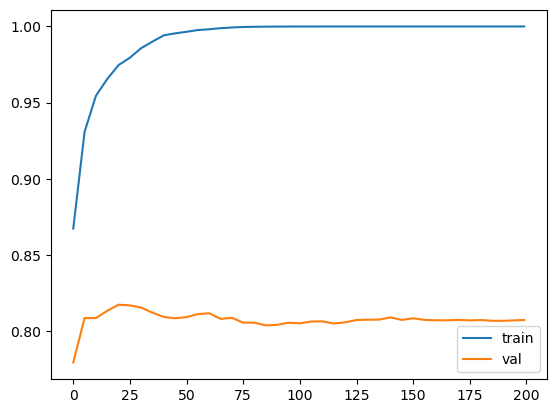

In [67]:
plt.plot(df_results.idx, df_results.train_auc, label = 'train')
plt.plot(df_results.idx, df_results.val_auc, label = 'val')
plt.legend()

## XGBoost Parameter Tuning
Tuning the following parameters:

- `eta`
- `max_depth`
- `min_child_weight`

#### Tuning `eta`

In [ ]:
scores = {}

In [103]:
%%capture output

# eta = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0]:
eta = 1.0
xgb_params = {
    'eta': eta, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [104]:
scores[f'eta={eta}'] = parse_xgb_output(output)

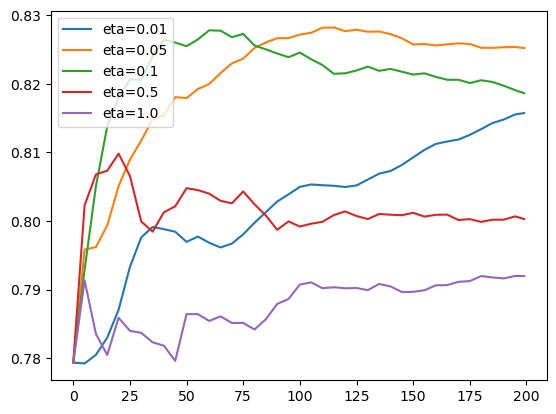

In [106]:
from IPython.display import display

etas = [0.01, 0.05, 0.1, 0.5, 1.0]
for eta in etas:
    df_eta = scores[f'eta={eta}']
    # display(df_eta)
    plt.plot(df_eta.idx, df_eta.val_auc, label=f'eta={eta}')
plt.legend()

In [ ]:
# eta=0.1的model，效果最好
# 虽然eta=0.5也表现不错，但是他是在iteration到100之后才跟eta=0.1的最高值持平，训练成本太高

#### Tuning `max_depth`

In [107]:
scores = {}

In [112]:
%%capture output

# eta = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0]:
max_depth=10
xgb_params = {
    'eta': 0.1, 
    'max_depth': max_depth,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [113]:
scores[f'max_depth={max_depth}'] = parse_xgb_output(output)

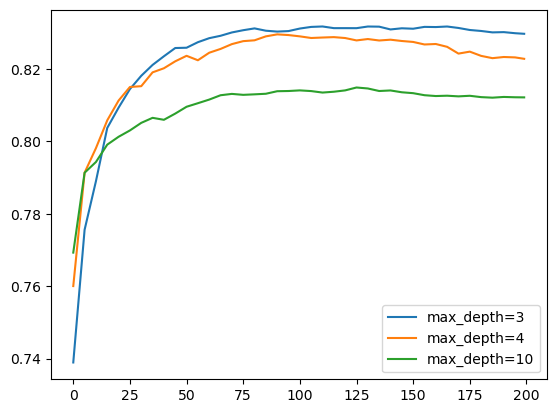

In [117]:
max_depths = [3,4,10]

for max_depth in max_depths:
    df_max_depth = scores[f'max_depth={max_depth}']
    
    plt.plot(df_max_depth.idx, df_max_depth.val_auc, label=f'max_depth={max_depth}')
plt.legend()

In [ ]:
# max_depth=3

#### Tuning num_child_weight

In [119]:
scores={}

In [126]:
%%capture output

# eta = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0]:
num_child_weight=30
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': num_child_weight,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [127]:
scores[f'num_child_weight={num_child_weight}'] = parse_xgb_output(output)

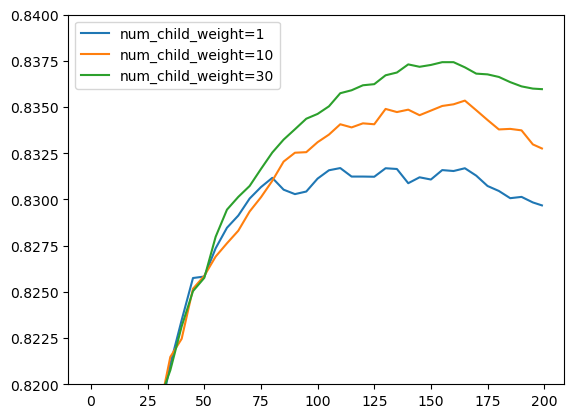

In [134]:
num_child_weights = [1,10,30]

for num_child_weight in num_child_weights:
    df_num_child_weight = scores[f'num_child_weight={num_child_weight}']
    
    plt.plot(df_num_child_weight.idx, 
             df_num_child_weight.val_auc, 
             label=f'num_child_weight={num_child_weight}')
plt.ylim(0.82, 0.84)
plt.legend()

In [ ]:
# num_child_weight=30

#### Prepare Final Model

In [135]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=150)

#### Other useful parameters
- `subsample` and `colsample_bytree`
- `lambda` and `alpha`

## Select the Final Model
- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

#### Decision Tree

In [138]:
from sklearn.tree import DecisionTreeClassifier

In [141]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [150]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7389079944782155

In [139]:
from sklearn.ensemble import RandomForestClassifier

In [143]:
rf = RandomForestClassifier(n_estimators = 200,
                           max_depth = 10,
                           min_samples_leaf = 3,
                           random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [152]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [140]:
import xgboost as xgb

In [144]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=150)

In [156]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8373465161899687

In [157]:
df_full_train = df_full_train.reset_index(drop=True)

In [158]:
y_full_train = (df_full_train['status'] == 'default').astype(int)

In [159]:
del df_full_train['status']

In [161]:
dict_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)

In [163]:
dict_test = df_test.to_dict(orient='records')

X_test = dv.transform(dict_test)

In [165]:
featurs = dv.get_feature_names_out()
dfulltrain= xgb.DMatrix(X_full_train, label=y_full_train, feature_names=list(featurs))
dtest= xgb.DMatrix(X_test, feature_names=list(featurs))

In [166]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=150)

In [167]:
y_pred = model.predict(dtest)

In [168]:
roc_auc_score(y_test, y_pred)

0.8323823371291725